CFE Data Assimilation of USGS streamflow data. Synthetic Forcing Data example to test methodology and 1-18 hour forecast. 

In [1]:
import time
import numpy as np
import pandas as pd
import hydroeval as he
import json
import matplotlib.pyplot as plt
import sys
from datetime import date
from datetime import datetime, timedelta

sys.path.insert(0, './CFE')
import bmi_cfe_open
import bmi_cfe_enkf_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI


(750.0, 780.0)

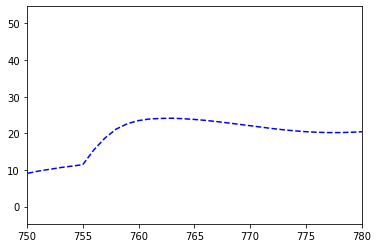

In [2]:
# Get Synthetic Observations (USGS)
cfe_obs = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_obs.initialize(cfg_file='./CFE/config_cfe_synthetic.json')

# Open forcing file
with open(cfe_obs.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
# Make empty list to plot
OBSERVATIONS_LIST = []

# Loop through precipitation in forcing data to set values
for i, precip in enumerate(df_forcing['APCP_surface_0']): #i is RAINRATE
    cfe_obs.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) 
    cfe_obs.update()
    # Get streamflow based on sin wave to see variation in synthetic observed streamflow
    OBSERVATIONS_LIST.append(cfe_obs.get_value('land_surface_water__runoff_depth') + np.sin(i/5) * 2)

cfe_obs.finalize()

# See plot to make sure it works
plt.plot(OBSERVATIONS_LIST,color = 'blue', linestyle='dashed')
plt.xlim(750,780)

In [3]:
## Open BMI's for each file
#cfe_open = bmi_cfe_open.BMI_CFE()
cfe_open = bmi_cfe_enkf_peturb.BMI_CFE() #One BMI to rule them all
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_enkf_peturb.BMI_CFE() #true model in the end with updated state vars

enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()

In [4]:
# Initialize Case study files
cfe_open.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
cfe_analysis.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
enkf.initialize(cfg_file='./Assimilation/EnKF_config-synthetic.json') # Need to create this still

initialized 10


In [5]:
print(bmi_cfe_open)
print(bmi_cfe_enkf_peturb)
print(Bmi_da_ENKF_forSBMI)

<module 'bmi_cfe_open' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_open.py'>
<module 'bmi_cfe_enkf_peturb' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_enkf_peturb.py'>
<module 'Bmi_da_ENKF_forSBMI' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./Assimilation\\Bmi_da_ENKF_forSBMI.py'>


In [6]:
# with open(cfe_open.forcing_file, 'r') as f:
#     df_forcing = pd.read_csv(f)
    
# print(df_forcing)
#plt.plot(df_forcing['APCP_surface'])

#values = df_forcing['APCP_surface']
#print(values)

In [7]:
#Make empty matrices for plotting
# cfeOpen = []
# cfePeturbed = []
# cfeAnalysis = []
# cfeEnKF = []

n_loop = 2
cfeOpen_ensa=[]
cfeAnalysis_ens=[]
## Loop through 100 different precipitation files for forcing 
for loop in range(n_loop):
    p = 'APCP_surface_' + str(loop)
    
    cfeOpen = []
    cfePeturbed = []
    cfeAnalysis = []
    cfeEnKF = []
    # Initialize Case study files
    cfe_open.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
    cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
    cfe_analysis.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
    enkf.initialize(cfg_file='./Assimilation/EnKF_config-synthetic.json') # Need to create this still
    ## Loop through time. Set values for each model and get values
    for i, precip in enumerate(df_forcing[str(p)]): #i is RAINRATE

        # Set values for each model
        cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3) #value of precip from forcing data in loop
        cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3)
        cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3)

        obs = OBSERVATIONS_LIST[i]
        enkf.set_value('validity', 1)

        if i>=768:
            enkf.set_value('validity', 0)

        # Update CFE open and peturbed. Get value for peturbed stats. 
        cfe_open.update()
        cfe_peturbed.update()

        # Get state vars from Peturbed. These are values as enkf uses
        soil_storage_avail = cfe_peturbed.get_value('soil_storage_avail_m')
        soil_reservoir_storage_deficit = cfe_peturbed.get_value('soil_reservoir_storage_deficit_out_m')
        surface_runoff = cfe_peturbed.get_value('land_surface_water__runoff_volume_flux')

        # Get values for plotting
        outflow = cfe_open.get_value('land_surface_water__runoff_depth')
        cfeOpen.append(outflow) #for plotting
        outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')

        # Get mean and covariance for stats of ensemble runs for EnKF
        outflow_peturb_mean = np.mean(outflow_peturb)
        outflow_peturb_covar = np.cov(outflow_peturb)
        cfePeturbed.append(outflow_peturb_mean) # For plotting

        # Set EnKF value to usgs, mean, and covariance. Get value from it then update
        enkf.set_value('soil_storage_avail_m', soil_storage_avail) #setting soil storage in enkf
        enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) #setting soil storage in enkf
        enkf.set_value('surface_runoff_depth_m', surface_runoff) #setting soil storage in enkf

        enkf.set_value('x', np.array([outflow_peturb_mean]))
        enkf.set_value('P', np.array([outflow_peturb_covar]))
        enkf.set_value('z', np.array([obs]))
        enkf.update()

        # For plotting
        outflow_enkf = enkf.get_value('enkf')
        cfeEnKF.append(outflow_enkf)

        # Get new EnKF state vars to give back to CFE Analysis
        state_transition_soil_storage = enkf.get_value('soil_storage_avail_m')
        state_transition_soil_res     = enkf.get_value('soil_reservoir_storage_deficit_updated_m')
        state_transition_runoff_factor= enkf.get_value('surface_runoff_ratio')

        # Set value for CFE analysis based on the state variable change from the EnKF factor to get true streamflow
        cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage)    
        cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res)  
        cfe_analysis.set_value('state_var_change_runoff',state_transition_runoff_factor)
        cfe_analysis.update() #get new streamflow value based on state var change

        # For plotting
        outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_depth')
        cfeAnalysis.append(outflow_analysis) 

        # Get values from new CFE analysis to put back into CFE Peturbed to keep look and EnKF going
        cfe_updated_everything_soil_storage = cfe_analysis.get_value('soil_storage_avail_m')
        cfe_updated_everything_soil_res = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
        cfe_updated_everything_runoff = cfe_analysis.get_value('state_var_change_runoff')

        # Set value from CFE analysis state variables back into CFE Peturbed to continue EnKF loop
        cfe_peturbed.set_value('soil_storage_avail_m', cfe_updated_everything_soil_storage)
        cfe_peturbed.set_value('soil_reservoir_storage_deficit_m', cfe_updated_everything_soil_res)
        cfe_peturbed.set_value('state_var_change_runoff', cfe_updated_everything_runoff)
    
    # predicted values
    cfeOpen_error=cfe_open#.subtract(OBSERVATIONS_LIST[769:])
    cfeAnalysis_error=cfeAnalysis#[769:]#.subtract(OBSERVATIONS_LIST[769:])
    # reaults of 100
    cfeOpen_ensa.append(np.divide(abs(np.subtract(cfeOpen[767:],OBSERVATIONS_LIST[767:])),OBSERVATIONS_LIST[767:]))
    cfeAnalysis_ens.append(np.divide(abs(np.subtract(cfeAnalysis[767:],OBSERVATIONS_LIST[767:])),OBSERVATIONS_LIST[767:]))
    
    # mean of 100
    # print("open",cfeOpen)
    # print("obs2",OBSERVATIONS_LIST)
    # print("analysis-obs",cfeAnalysis_ens)
    cfeOpen_ensa_mean=np.mean(cfeOpen_ensa,axis=0)
    cfeanalys_ensa_mean=np.mean(cfeAnalysis_ens,axis=0)
    # Finalize models
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
cfe_analysis.finalize(print_mass_balance=True)
enkf.finalize()



initialized 10
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3121136221931379
EnKF Code predicted, X Post [9.43848418]
surface_runoff_ratio [2.16166509]
Leftover vol 0.0
surface _runoff [2.16166509]
***********over estimaiton ratio [1.]
Observation BMI [9.14803171]
CFE [22.56461842]
enkf [9.43848418]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2957114578598735
EnKF Code predicted, X Post [16.77624014]
surface_runoff_ratio [3.86476543]
Leftover vol 0.0
surface _runoff [3.86476543]
***********over estimaiton ratio [1.]
Observation BMI [16.75252741]
CFE [31.77146698]
enkf [16.77624014]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.28072802840953426
EnKF Code predicted, X Post [22.68147851]
surface_runoff_ratio [2.36045377]
Leftover vol [26.41468619]
surface _runoff [2.36045377]
***********over estimaiton ratio [0.46198066]
Observation BMI [22.40183725]
CFE [49.0961647]
enkf [22.68147

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2210197691697241
EnKF Code predicted, X Post [0.40454908]
***********under estimaiton ratio [56.53261181]
Observation BMI [0.99485675]
CFE [0.00715603]
enkf [0.40454908]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.22803732534159116
EnKF Code predicted, X Post [0.84358329]
***********under estimaiton ratio [142.41704331]
Observation BMI [1.32081998]
CFE [0.00592333]
enkf [0.84358329]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.23494081468379835
EnKF Code predicted, X Post [0.61572307]
***********under estimaiton ratio [82.50153351]
Observation BMI [1.59439688]
CFE [0.00746317]
enkf [0.61572307]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2417320912950247
EnKF Code predicted, X Post [1.46855277]
***********under estimaiton ratio [189.78873003]
Observation BMI [1.80468904]
CFE [0.00773783]
enkf [1.46

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.19196331853728998
EnKF Code predicted, X Post [0.2059414]
***********under estimaiton ratio [2.19785824]
Observation BMI [0.25721593]
CFE [0.09370095]
enkf [0.2059414]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.19945317263220008
EnKF Code predicted, X Post [-0.72449488]
surface_runoff_ratio [0.00113103]
Leftover vol 0.0
surface _runoff [0.00113103]
***********over estimaiton ratio [1.]
Observation BMI [-0.16945184]
CFE [0.01765237]
enkf [-0.72449488]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.20682128293335944
EnKF Code predicted, X Post [-0.46756473]
surface_runoff_ratio [0.00114187]
Leftover vol 0.0
surface _runoff [0.00114187]
***********over estimaiton ratio [1.]
Observation BMI [-0.56130751]
CFE [0.01445121]
enkf [-0.46756473]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2140696283246194
EnK

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.26141014322674394
EnKF Code predicted, X Post [0.38110919]
***********under estimaiton ratio [18.49661744]
Observation BMI [1.77719031]
CFE [0.02060426]
enkf [0.38110919]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2677711742772404
EnKF Code predicted, X Post [0.53560003]
***********under estimaiton ratio [25.28354585]
Observation BMI [1.55290837]
CFE [0.02118374]
enkf [0.53560003]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.27402880998218804
EnKF Code predicted, X Post [1.06791125]
***********under estimaiton ratio [51.48996307]
Observation BMI [1.26745778]
CFE [0.02074018]
enkf [1.06791125]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.28018473098068386
EnKF Code predicted, X Post [0.8785994]
***********under estimaiton ratio [35.29723487]
Observation BMI [0.93221961]
CFE [0.02489145]
enkf [0.8785

surface _runoff [0.04081915]
***********over estimaiton ratio [1.]
Observation BMI [0.10063537]
CFE [0.52144353]
enkf [0.49081816]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.19161927123074185
EnKF Code predicted, X Post [-0.83368343]
surface_runoff_ratio [0.02118003]
Leftover vol 0.0
surface _runoff [0.02118003]
***********over estimaiton ratio [1.]
Observation BMI [-0.37765773]
CFE [0.30506336]
enkf [-0.83368343]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1991147176407756
EnKF Code predicted, X Post [0.10268359]
***********under estimaiton ratio [5.69929191]
Observation BMI [-0.83681193]
CFE [0.0180169]
enkf [0.10268359]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.20648832935680195
EnKF Code predicted, X Post [-1.05835007]
surface_runoff_ratio [0.00154274]
Leftover vol 0.0
surface _runoff [0.00154274]
***********over estimaiton ratio [1.]
Observation BMI [-1.17878396]
CFE [

EnKF Code predicted, X Post [2.33312372]
surface_runoff_ratio [0.51392858]
Leftover vol 0.0
surface _runoff [0.51392858]
***********over estimaiton ratio [1.]
Observation BMI [1.71173649]
CFE [5.49228325]
enkf [2.33312372]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.16832861382364694
EnKF Code predicted, X Post [2.52531121]
surface_runoff_ratio [0.25701125]
Leftover vol 0.0
surface _runoff [0.25701125]
***********over estimaiton ratio [1.]
Observation BMI [0.87630582]
CFE [3.14752708]
enkf [2.52531121]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.17620263810125403
EnKF Code predicted, X Post [0.90818462]
surface_runoff_ratio [0.11693009]
Leftover vol 0.0
surface _runoff [0.11693009]
***********over estimaiton ratio [1.]
Observation BMI [0.60940754]
CFE [1.20875805]
enkf [0.90818462]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.18394867409290871
EnKF Code predicted, X Post [1.056

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.18391882634825008
EnKF Code predicted, X Post [-0.31462425]
surface_runoff_ratio [0.04751355]
Leftover vol 0.0
surface _runoff [0.04751355]
***********over estimaiton ratio [1.]
Observation BMI [-0.46852133]
CFE [0.4649581]
enkf [-0.31462425]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.19153943959887676
EnKF Code predicted, X Post [-0.472036]
surface_runoff_ratio [0.01476341]
Leftover vol 0.0
surface _runoff [0.01476341]
***********over estimaiton ratio [1.]
Observation BMI [-0.95889117]
CFE [0.19350613]
enkf [-0.472036]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.19903618363174813
EnKF Code predicted, X Post [0.03583185]
***********under estimaiton ratio [1.39357085]
Observation BMI [-1.40471245]
CFE [0.02571225]
enkf [0.03583185]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.20641107187840868
EnKF

***********under estimaiton ratio [46.25137941]
Observation BMI [2.02017731]
CFE [0.02170243]
enkf [1.00376733]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.22780652316072458
EnKF Code predicted, X Post [0.76559557]
***********under estimaiton ratio [35.3657885]
Observation BMI [1.98137273]
CFE [0.02164791]
enkf [0.76559557]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.23471376407575928
EnKF Code predicted, X Post [1.34333707]
***********under estimaiton ratio [52.39382303]
Observation BMI [1.86437992]
CFE [0.02563923]
enkf [1.34333707]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.24150873127989247
EnKF Code predicted, X Post [0.32833545]
***********under estimaiton ratio [23.01182441]
Observation BMI [1.67386318]
CFE [0.01426812]
enkf [0.32833545]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.248193249725564
EnKF Code predicted, X Post [0.30677

EnKF Code predicted, X Post [-1.01734756]
surface_runoff_ratio [0.00159121]
Leftover vol 0.0
surface _runoff [0.00159121]
***********over estimaiton ratio [1.]
Observation BMI [-0.75534443]
CFE [0.01804501]
enkf [-1.01734756]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.261226543183247
EnKF Code predicted, X Post [0.06333848]
***********under estimaiton ratio [3.68404148]
Observation BMI [-0.37364041]
CFE [0.01719266]
enkf [0.06333848]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.26759055855967884
EnKF Code predicted, X Post [0.62350131]
***********under estimaiton ratio [35.50545792]
Observation BMI [0.02376269]
CFE [0.01756072]
enkf [0.62350131]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2738511300818517
EnKF Code predicted, X Post [0.08856298]
***********under estimaiton ratio [4.47354882]
Observation BMI [0.42102136]
CFE [0.01979703]
enkf [0.08856298]
Beginning-------------

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2920209299140841
EnKF Code predicted, X Post [-1.55425093]
surface_runoff_ratio [0.00158662]
Leftover vol 0.0
surface _runoff [0.00158662]
***********over estimaiton ratio [1.]
Observation BMI [-1.63748089]
CFE [0.01668691]
enkf [-1.55425093]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2978843980943583
EnKF Code predicted, X Post [-0.75900208]
surface_runoff_ratio [0.00158502]
Leftover vol 0.0
surface _runoff [0.00158502]
***********over estimaiton ratio [1.]
Observation BMI [-1.82677484]
CFE [0.01479092]
enkf [-0.75900208]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3036525585621247
EnKF Code predicted, X Post [-1.00324301]
surface_runoff_ratio [0.00158318]
Leftover vol 0.0
surface _runoff [0.00158318]
***********over estimaiton ratio [1.]
Observation BMI [-1.94244106]
CFE [0.01704118]
enkf [-1.00324301]
Beginning-------------------

EnKF Code predicted, X Post [1.1286022]
***********under estimaiton ratio [54.61960946]
Observation BMI [1.87633579]
CFE [0.02066295]
enkf [1.1286022]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.32039490283533345
EnKF Code predicted, X Post [0.8345357]
***********under estimaiton ratio [50.39542337]
Observation BMI [1.69139506]
CFE [0.01655975]
enkf [0.8345357]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.32579716642290957
EnKF Code predicted, X Post [-0.03502342]
surface_runoff_ratio [0.00157349]
Leftover vol 0.0
surface _runoff [0.00157349]
***********over estimaiton ratio [1.]
Observation BMI [1.43981931]
CFE [0.0188327]
enkf [-0.03502342]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3311116189455894
EnKF Code predicted, X Post [0.60069317]
***********under estimaiton ratio [28.12130702]
Observation BMI [1.13163667]
CFE [0.02136078]
enkf [0.60069317]
Beginning----------------

***********under estimaiton ratio [9.90602638]
Observation BMI [1.1244351]
CFE [0.01925884]
enkf [0.19077858]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2688714799336628
EnKF Code predicted, X Post [1.25241627]
***********under estimaiton ratio [59.07164815]
Observation BMI [1.43347785]
CFE [0.02120165]
enkf [1.25241627]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.27511123072614074
EnKF Code predicted, X Post [0.4444968]
***********under estimaiton ratio [19.41255107]
Observation BMI [1.68611276]
CFE [0.02289739]
enkf [0.4444968]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2812495575223821
EnKF Code predicted, X Post [1.38545395]
***********under estimaiton ratio [91.33994755]
Observation BMI [1.87226811]
CFE [0.01516811]
enkf [1.38545395]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.287288108918197
EnKF Code predicted, X Post [0.73018628]


Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.4863264888855787
EnKF Code predicted, X Post [-0.96146836]
surface_runoff_ratio [0.00122971]
Leftover vol 0.0
surface _runoff [0.00122971]
***********over estimaiton ratio [1.]
Observation BMI [-1.98427576]
CFE [0.01935666]
enkf [-0.96146836]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.4890316183857836
EnKF Code predicted, X Post [-1.24977628]
surface_runoff_ratio [0.00122109]
Leftover vol 0.0
surface _runoff [0.00122109]
***********over estimaiton ratio [1.]
Observation BMI [-1.9483842]
CFE [0.01024]
enkf [-1.24977628]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.49169277737284245
EnKF Code predicted, X Post [3.43893907]
surface_runoff_ratio [1.08025027]
Leftover vol 0.0
surface _runoff [1.08025027]
***********over estimaiton ratio [1.]
Observation BMI [2.71713377]
CFE [14.87619216]
enkf [3.43893907]
Beginning------------------------

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.17824504614718317
EnKF Code predicted, X Post [18.14304236]
surface_runoff_ratio [1.28548942]
Leftover vol [14.97101956]
surface _runoff [1.28548942]
***********over estimaiton ratio [0.5478954]
Observation BMI [17.43384083]
CFE [33.11406192]
enkf [18.14304236]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.17342826553611745
EnKF Code predicted, X Post [16.97626614]
surface_runoff_ratio [1.0758941]
Leftover vol [18.30412482]
surface _runoff [1.0758941]
***********over estimaiton ratio [0.48118135]
Observation BMI [17.05413979]
CFE [35.28039095]
enkf [16.97626614]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1690281385700264
EnKF Code predicted, X Post [16.73870498]
surface_runoff_ratio [2.08033443]
Leftover vol 0.0
surface _runoff [2.08033443]
***********over estimaiton ratio [1.]
Observation BMI [16.65809157]
CFE [27.4110119]
enkf [16.7

EnKF Code predicted, X Post [0.50006273]
***********under estimaiton ratio [40.37644809]
Observation BMI [1.665935]
CFE [0.01238501]
enkf [0.50006273]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.44473569212405073
EnKF Code predicted, X Post [0.99189689]
***********under estimaiton ratio [75.25481817]
Observation BMI [1.85762268]
CFE [0.01318051]
enkf [0.99189689]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.44811685901012427
EnKF Code predicted, X Post [1.06404613]
***********under estimaiton ratio [78.26622705]
Observation BMI [1.97589563]
CFE [0.01359521]
enkf [1.06404613]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.4514430667369407
EnKF Code predicted, X Post [0.9483364]
***********under estimaiton ratio [55.26164917]
Observation BMI [2.01603591]
CFE [0.01716084]
enkf [0.9483364]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.454715208637863

EnKF Code predicted, X Post [10.75053343]
surface_runoff_ratio [2.09605843]
Leftover vol 0.0
surface _runoff [2.09605843]
***********over estimaiton ratio [1.]
Observation BMI [11.05608614]
CFE [24.09063207]
enkf [10.75053343]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.31641655035704797
EnKF Code predicted, X Post [11.2607441]
surface_runoff_ratio [2.23666064]
Leftover vol 0.0
surface _runoff [2.23666064]
***********over estimaiton ratio [1.]
Observation BMI [11.45738926]
CFE [22.35000415]
enkf [11.2607441]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.29966732535993434
EnKF Code predicted, X Post [15.59735339]
surface_runoff_ratio [1.10504229]
Leftover vol [30.45226731]
surface _runoff [1.10504229]
***********over estimaiton ratio [0.33870753]
Observation BMI [15.50884448]
CFE [46.0496207]
enkf [15.59735339]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.284345475892271
EnKF Code

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.22313454415041878
EnKF Code predicted, X Post [30.16135175]
surface_runoff_ratio [2.32903818]
Leftover vol [24.30696788]
surface _runoff [2.32903818]
***********over estimaiton ratio [0.55374118]
Observation BMI [29.70309701]
CFE [54.46831963]
enkf [30.16135175]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2144276355463317
EnKF Code predicted, X Post [30.12315596]
surface_runoff_ratio [2.09434514]
Leftover vol [36.16267929]
surface _runoff [2.09434514]
***********over estimaiton ratio [0.45444333]
Observation BMI [29.73340401]
CFE [66.28583525]
enkf [30.12315596]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2064735842408726
EnKF Code predicted, X Post [30.171663]
surface_runoff_ratio [2.16726568]
Leftover vol [30.26062193]
surface _runoff [2.16726568]
***********over estimaiton ratio [0.49926398]
Observation BMI [29.68385366]
CFE [60.4

EnKF Code predicted, X Post [4.52264089]
surface_runoff_ratio [0.38366593]
Leftover vol [12.44753633]
surface _runoff [0.38366593]
***********over estimaiton ratio [0.26650522]
Observation BMI [4.23898766]
CFE [16.97017722]
enkf [4.52264089]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12301989388858214
EnKF Code predicted, X Post [4.71904716]
surface_runoff_ratio [1.21237196]
Leftover vol 0.0
surface _runoff [1.21237196]
***********over estimaiton ratio [1.]
Observation BMI [4.47738074]
CFE [9.59470351]
enkf [4.71904716]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12298150357213822
EnKF Code predicted, X Post [5.7555517]
surface_runoff_ratio [0.53351282]
Leftover vol [12.87605253]
surface _runoff [0.53351282]
***********over estimaiton ratio [0.30891337]
Observation BMI [4.64721384]
CFE [18.63160423]
enkf [5.7555517]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1229472426608253

Leftover vol [10.70776496]
surface _runoff [0.30561023]
***********over estimaiton ratio [0.25730586]
Observation BMI [1.90896616]
CFE [14.41746259]
enkf [3.70969763]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12266362664206554
EnKF Code predicted, X Post [0.40773492]
surface_runoff_ratio [0.02937486]
Leftover vol [10.77324347]
surface _runoff [0.02937486]
***********over estimaiton ratio [0.03646684]
Observation BMI [0.67698065]
CFE [11.18097839]
enkf [0.40773492]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12266802522483322
EnKF Code predicted, X Post [0.46787578]
surface_runoff_ratio [0.49484626]
Leftover vol 0.0
surface _runoff [0.49484626]
***********over estimaiton ratio [1.]
Observation BMI [-0.1041944]
CFE [6.33849978]
enkf [0.46787578]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12266700530865315
EnKF Code predicted, X Post [0.22966195]
surface_runoff_ratio [0.017184

Leftover vol [15.57674941]
surface _runoff [0.09983948]
***********over estimaiton ratio [0.09572891]
Observation BMI [0.74839529]
CFE [17.22575184]
enkf [1.64900243]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12270525578968439
EnKF Code predicted, X Post [0.22365007]
surface_runoff_ratio [0.72792827]
Leftover vol 0.0
surface _runoff [0.72792827]
***********over estimaiton ratio [1.]
Observation BMI [0.10063537]
CFE [9.37130344]
enkf [0.22365007]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1226972719363465
EnKF Code predicted, X Post [0.08556734]
surface_runoff_ratio [0.00860518]
Leftover vol [10.75424377]
surface _runoff [0.00860518]
***********over estimaiton ratio [0.0078938]
Observation BMI [-0.37765773]
CFE [10.83981111]
enkf [0.08556734]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12269034230306042
EnKF Code predicted, X Post [-7.07207247e-06]
surface_runoff_ratio [-5.2

soil_storage_deficit_from CFE 0.12274857206635914
EnKF Code predicted, X Post [1.88088913]
surface_runoff_ratio [0.16051892]
Leftover vol [10.64327629]
surface _runoff [0.16051892]
***********over estimaiton ratio [0.1501808]
Observation BMI [1.72182081]
CFE [12.52416541]
enkf [1.88088913]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12273751481335149
EnKF Code predicted, X Post [2.80257212]
surface_runoff_ratio [0.87178074]
Leftover vol 0.0
surface _runoff [0.87178074]
***********over estimaiton ratio [1.]
Observation BMI [1.89664409]
CFE [10.74640309]
enkf [2.80257212]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12272473445525134
EnKF Code predicted, X Post [1.80858334]
surface_runoff_ratio [0.10039002]
Leftover vol [31.45712958]
surface _runoff [0.10039002]
***********over estimaiton ratio [0.05436779]
Observation BMI [1.99665049]
CFE [33.26571292]
enkf [1.80858334]
Beginning----------------------------
self.f 

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12258552390114774
EnKF Code predicted, X Post [-1.04748407]
surface_runoff_ratio [-0.0697266]
Leftover vol [16.94682988]
surface _runoff [-0.0697266]
***********over estimaiton ratio [-0.06588221]
Observation BMI [-0.95889117]
CFE [15.89934581]
enkf [-1.04748407]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12258687236942378
EnKF Code predicted, X Post [-1.11718349]
surface_runoff_ratio [0.66876488]
Leftover vol 0.0
surface _runoff [0.66876488]
***********over estimaiton ratio [1.]
Observation BMI [-1.40471245]
CFE [7.73779841]
enkf [-1.11718349]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12258551322831357
EnKF Code predicted, X Post [-2.24121642]
surface_runoff_ratio [-0.14734446]
Leftover vol [14.7858146]
surface _runoff [-0.14734446]
***********over estimaiton ratio [-0.17865988]
Observation BMI [-1.65513312]
CFE [12.54459818]
enk

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1227031335944011
EnKF Code predicted, X Post [2.87434899]
surface_runoff_ratio [0.24859378]
Leftover vol [12.41645734]
surface _runoff [0.24859378]
***********over estimaiton ratio [0.1879789]
Observation BMI [1.86437992]
CFE [15.29080633]
enkf [2.87434899]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12269173889899765
EnKF Code predicted, X Post [2.73710897]
surface_runoff_ratio [0.21372861]
Leftover vol [9.77725702]
surface _runoff [0.21372861]
***********over estimaiton ratio [0.21871735]
Observation BMI [1.67386318]
CFE [12.51436598]
enkf [2.73710897]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12268833787485645
EnKF Code predicted, X Post [1.40649395]
surface_runoff_ratio [0.65544418]
Leftover vol 0.0
surface _runoff [0.65544418]
***********over estimaiton ratio [1.]
Observation BMI [1.41741788]
CFE [9.23649956]
enkf [1.40649395]

surface_runoff_ratio [0.76990944]
Leftover vol 0.0
surface _runoff [0.76990944]
***********over estimaiton ratio [1.]
Observation BMI [-1.41201774]
CFE [9.44622025]
enkf [1.90802191]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12263010822677056
EnKF Code predicted, X Post [0.16702599]
surface_runoff_ratio [0.61050389]
Leftover vol 0.0
surface _runoff [0.61050389]
***********over estimaiton ratio [1.]
Observation BMI [-1.10613184]
CFE [7.5780433]
enkf [0.16702599]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12267866120271098
EnKF Code predicted, X Post [-0.67030518]
surface_runoff_ratio [-0.06350549]
Leftover vol [15.95604844]
surface _runoff [-0.06350549]
***********over estimaiton ratio [-0.04385166]
Observation BMI [-0.75534443]
CFE [15.28574326]
enkf [-0.67030518]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12266995652813484
EnKF Code predicted, X Post [0.40724351]
surface_

surface_runoff_ratio [-0.02947751]
Leftover vol [12.63282758]
surface _runoff [-0.02947751]
***********over estimaiton ratio [-0.02742467]
Observation BMI [-1.63748089]
CFE [12.29562416]
enkf [-0.33720341]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12271230697590285
EnKF Code predicted, X Post [-2.27202349]
surface_runoff_ratio [-0.16778069]
Leftover vol [12.13882157]
surface _runoff [-0.16778069]
***********over estimaiton ratio [-0.23026958]
Observation BMI [-1.82677484]
CFE [9.86679807]
enkf [-2.27202349]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12270285029423411
EnKF Code predicted, X Post [0.1719219]
surface_runoff_ratio [0.39271411]
Leftover vol 0.0
surface _runoff [0.39271411]
***********over estimaiton ratio [1.]
Observation BMI [-1.94244106]
CFE [5.72248358]
enkf [0.1719219]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12278202365776314
EnKF Code predicted, X Post 

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1226226710786299
EnKF Code predicted, X Post [2.53363573]
surface_runoff_ratio [0.67143459]
Leftover vol 0.0
surface _runoff [0.67143459]
***********over estimaiton ratio [1.]
Observation BMI [1.649592]
CFE [6.60447087]
enkf [2.53363573]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12262555027583477
EnKF Code predicted, X Post [1.76889185]
surface_runoff_ratio [0.11873603]
Leftover vol [21.45444141]
surface _runoff [0.11873603]
***********over estimaiton ratio [0.07616873]
Observation BMI [1.84750188]
CFE [23.22333326]
enkf [1.76889185]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1226211345655186
EnKF Code predicted, X Post [2.17468759]
surface_runoff_ratio [0.12677278]
Leftover vol [18.027081]
surface _runoff [0.12677278]
***********over estimaiton ratio [0.10764838]
Observation BMI [1.97255859]
CFE [20.20176859]
enkf [2.17468759]
Be

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1226192032781972
EnKF Code predicted, X Post [0.52994162]
surface_runoff_ratio [0.65583147]
Leftover vol 0.0
surface _runoff [0.65583147]
***********over estimaiton ratio [1.]
Observation BMI [-0.95766629]
CFE [9.36500393]
enkf [0.52994162]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12261516057485766
EnKF Code predicted, X Post [-1.05176782]
surface_runoff_ratio [-0.08372072]
Leftover vol [18.47778501]
surface _runoff [-0.08372072]
***********over estimaiton ratio [-0.06035618]
Observation BMI [-1.3559639]
CFE [17.42601718]
enkf [-1.05176782]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12261230700504622
EnKF Code predicted, X Post [-1.24357434]
surface_runoff_ratio [-0.07656864]
Leftover vol [16.79500728]
surface _runoff [-0.07656864]
***********over estimaiton ratio [-0.07996526]
Observation BMI [-1.67955196]
CFE [15.55143293]
enkf

surface_runoff_ratio [0.16674003]
Leftover vol [16.04195675]
surface _runoff [0.16674003]
***********over estimaiton ratio [0.14851744]
Observation BMI [1.20942178]
CFE [18.84002964]
enkf [2.79807289]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12276359466583053
EnKF Code predicted, X Post [1.35161123]
surface_runoff_ratio [0.9527143]
Leftover vol 0.0
surface _runoff [0.9527143]
***********over estimaiton ratio [1.]
Observation BMI [0.86659543]
CFE [8.67493232]
enkf [1.35161123]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12274770628046106
EnKF Code predicted, X Post [0.99257774]
surface_runoff_ratio [0.06693001]
Leftover vol [22.07763376]
surface _runoff [0.06693001]
***********over estimaiton ratio [0.04302422]
Observation BMI [0.48988303]
CFE [23.0702115]
enkf [0.99257774]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12273360852954562
EnKF Code predicted, X Post [1.57925886]

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12268911718531317
EnKF Code predicted, X Post [16.47960638]
surface_runoff_ratio [1.31806249]
Leftover vol [14.3507051]
surface _runoff [1.31806249]
***********over estimaiton ratio [0.53452611]
Observation BMI [16.14309573]
CFE [30.83031148]
enkf [16.47960638]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12267693224943177
EnKF Code predicted, X Post [17.40930191]
surface_runoff_ratio [1.56956036]
Leftover vol [10.70170015]
surface _runoff [1.56956036]
***********over estimaiton ratio [0.61930563]
Observation BMI [17.40948733]
CFE [28.11100207]
enkf [17.40930191]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12266669706999633
EnKF Code predicted, X Post [18.14931834]
surface_runoff_ratio [1.62913501]
Leftover vol [17.60861543]
surface _runoff [1.62913501]
***********over estimaiton ratio [0.5075606]
Observation BMI [18.11345346]
CFE [35

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1227777348198077
EnKF Code predicted, X Post [-0.18006267]
surface_runoff_ratio [0.72801103]
Leftover vol 0.0
surface _runoff [0.72801103]
***********over estimaiton ratio [1.]
Observation BMI [-1.91620753]
CFE [8.04427934]
enkf [-0.18006267]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.122770376905452
EnKF Code predicted, X Post [-1.29260532]
surface_runoff_ratio [-0.13727744]
Leftover vol [17.45526798]
surface _runoff [-0.13727744]
***********over estimaiton ratio [-0.07997478]
Observation BMI [-1.97957558]
CFE [16.16266266]
enkf [-1.29260532]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.122753154749496
EnKF Code predicted, X Post [-0.93400965]
surface_runoff_ratio [-0.0618903]
Leftover vol [20.22299025]
surface _runoff [-0.0618903]
***********over estimaiton ratio [-0.04842193]
Observation BMI [-1.96335311]
CFE [19.2889806]
enkf [-0

EnKF Code predicted, X Post [1.8385343]
surface_runoff_ratio [0.58892266]
Leftover vol 0.0
surface _runoff [0.58892266]
***********over estimaiton ratio [1.]
Observation BMI [0.8910028]
CFE [6.72846693]
enkf [1.8385343]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12285261042694362
EnKF Code predicted, X Post [0.83863909]
surface_runoff_ratio [0.0765009]
Leftover vol [10.97444458]
surface _runoff [0.0765009]
***********over estimaiton ratio [0.07099239]
Observation BMI [0.51643613]
CFE [11.81308366]
enkf [0.83863909]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12283115940565426
EnKF Code predicted, X Post [1.18393667]
surface_runoff_ratio [0.82776861]
Leftover vol 0.0
surface _runoff [0.82776861]
***********over estimaiton ratio [1.]
Observation BMI [0.12176815]
CFE [7.81670805]
enkf [1.18393667]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12280977673337667
EnKF Code predicted,

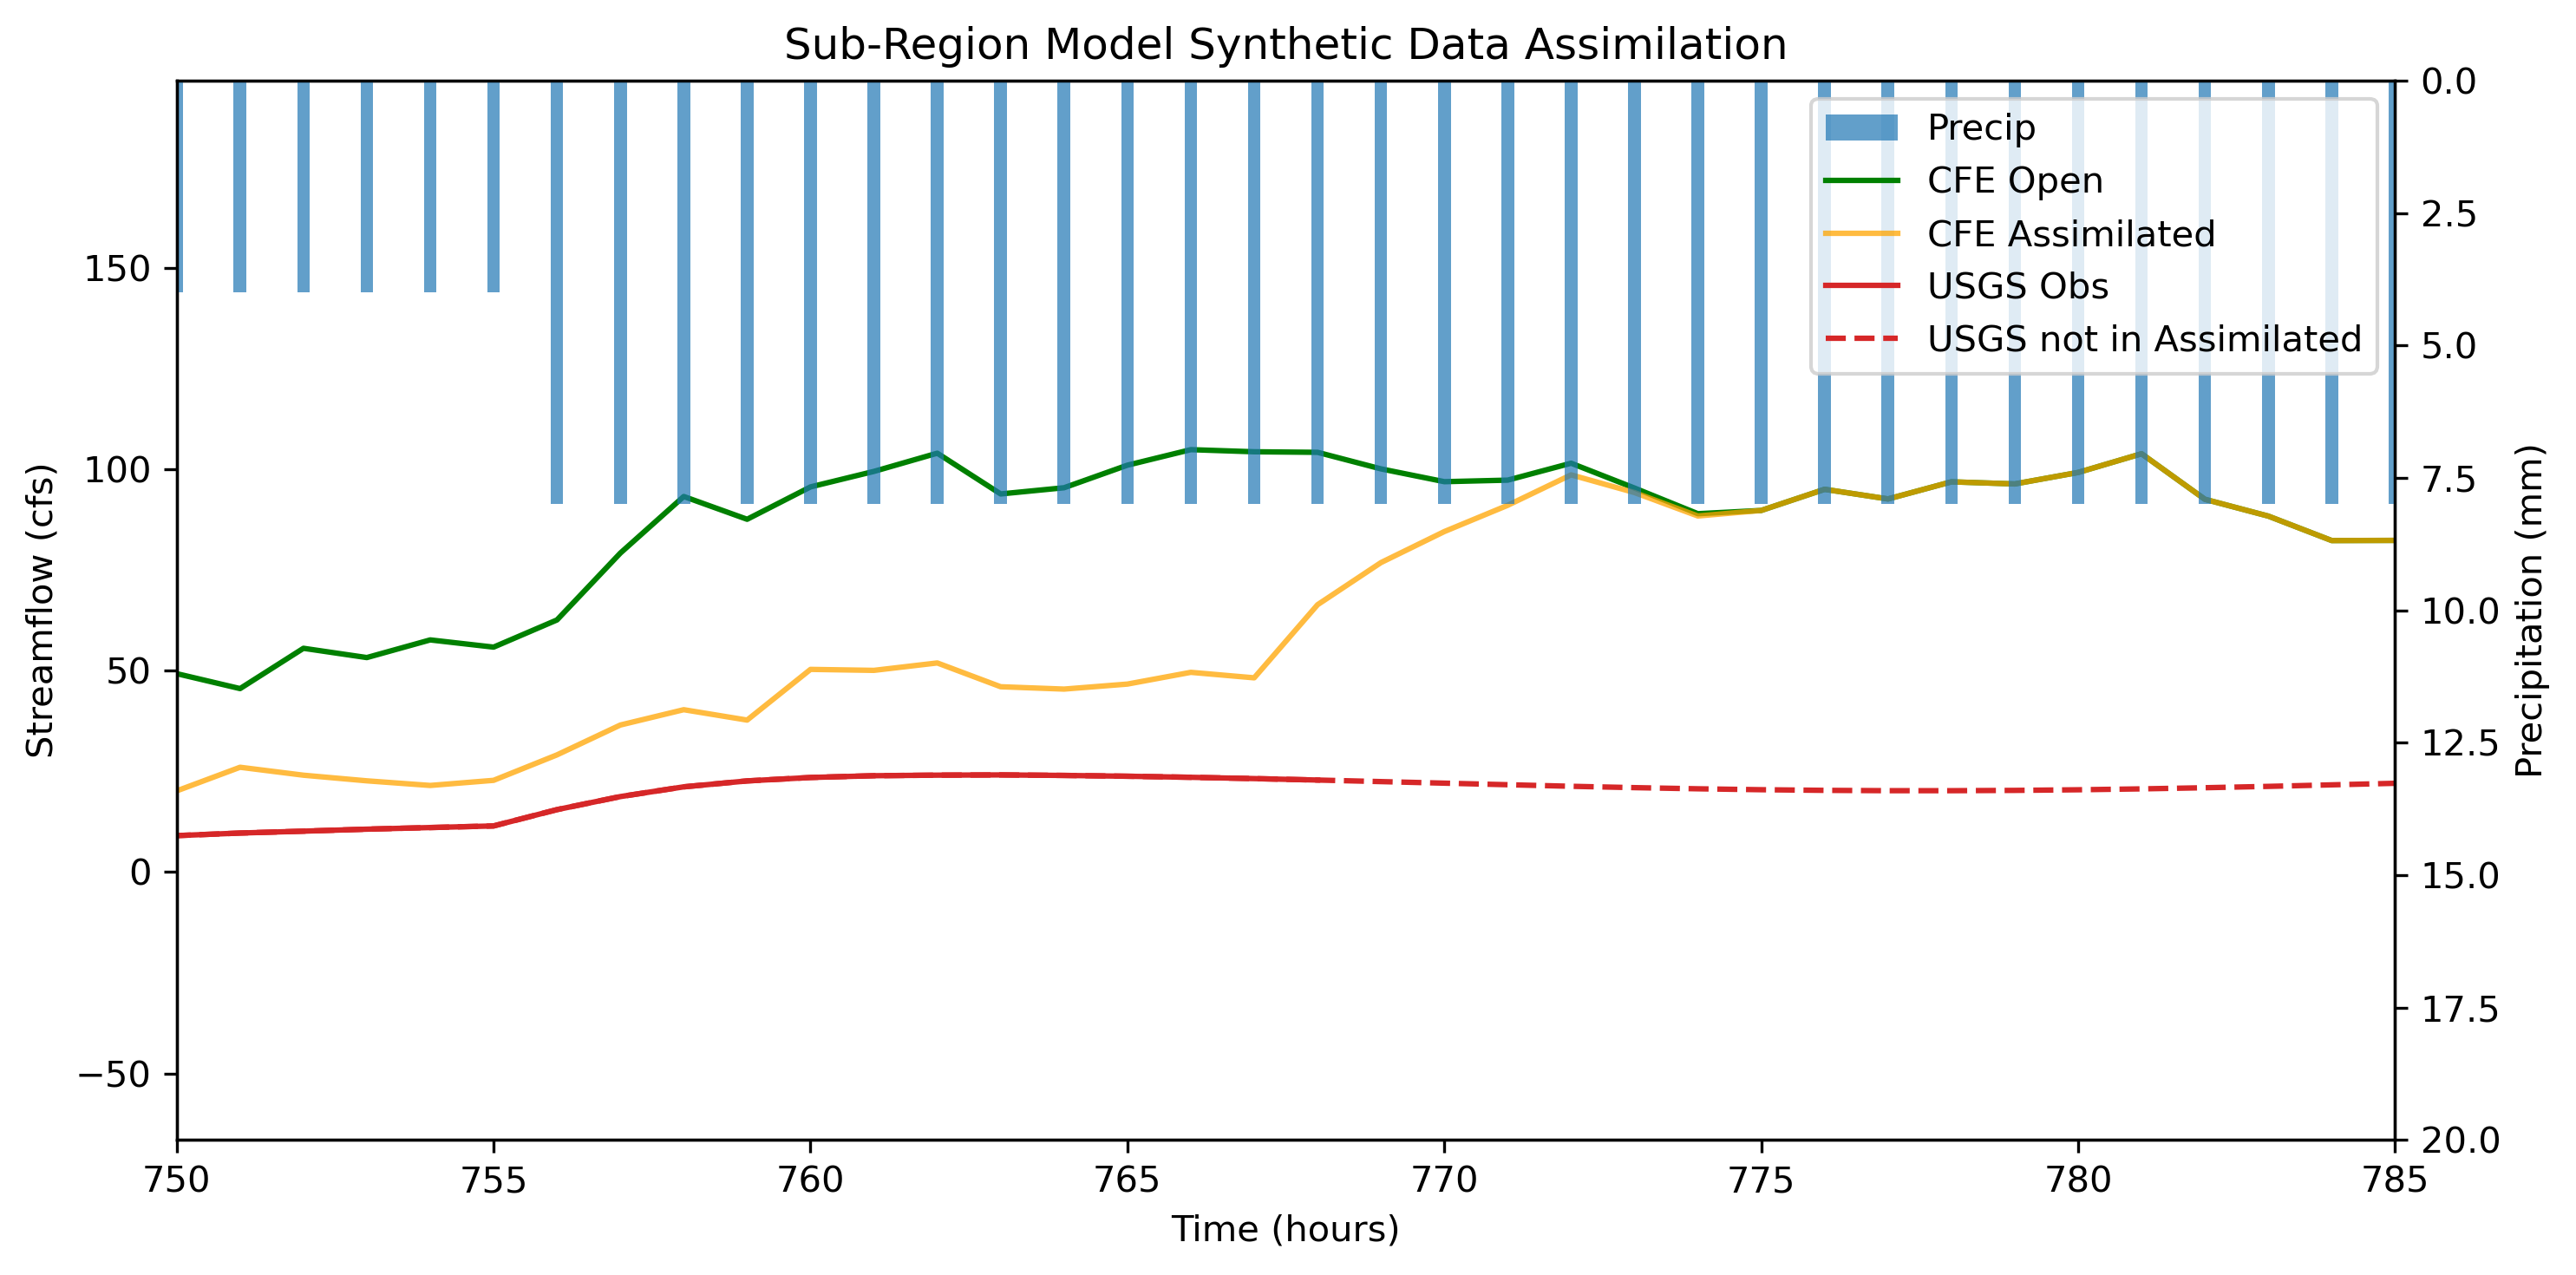

In [8]:
istart_plot=0
istart_plot_2=769
iend_plot=786
x = list(range(istart_plot, iend_plot))

Date_list = []
df_forcing['time'] = pd.to_datetime(df_forcing['time'], infer_datetime_format=True) 

fig, ax1 = plt.subplots(figsize = (10,5), dpi=300)

ax2 = ax1.twinx()

ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Streamflow (cfs)')
ax2.set_ylabel('Precipitation (mm)')
ax2.set_ylim(0,20,1)
ax2.invert_yaxis()
#ax1.set_ylim(0,50,1)
plt.xlim(750,785)

plt.title('Sub-Region Model Synthetic Data Assimilation')
Precip = ax2.bar(x, df_forcing['APCP_surface_0'],width=0.2,alpha=0.7, color="tab:blue", label = 'Precip')
#ax1.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:orange', label = 'CFE Peturbed')
Open, = ax1.plot(x, cfeOpen[istart_plot:iend_plot], color = 'green', label = 'CFE Open')
Analysis, = ax1.plot(x, cfeAnalysis[istart_plot:iend_plot], color = 'orange', alpha=0.75, label = 'CFE Assimilated')
Obs, = ax1.plot(OBSERVATIONS_LIST[istart_plot:769], color = 'tab:red', label = 'USGS Obs')
Obs2, = ax1.plot(OBSERVATIONS_LIST[istart_plot:iend_plot], color = 'tab:red', linestyle='dashed', label = 'USGS not in Assimilated')
#ax1.plot(x, cfeEnKF[istart_plot:iend_plot], color = 'tab:blue', label = 'EnKF')

#ax1.set_xlim([date(2017, 5, 15), date(2017, 6, 15)]) ## Customize date range for all plots
#ax1.tick_params(axis='x', labelrotation = 45)

plt.legend(handles = [Precip,Open,Analysis,Obs,Obs2], loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))

#plt.savefig("WorkingDA_7-19.png")
fig.tight_layout()
ax1.margins(x=0)

plt.show()


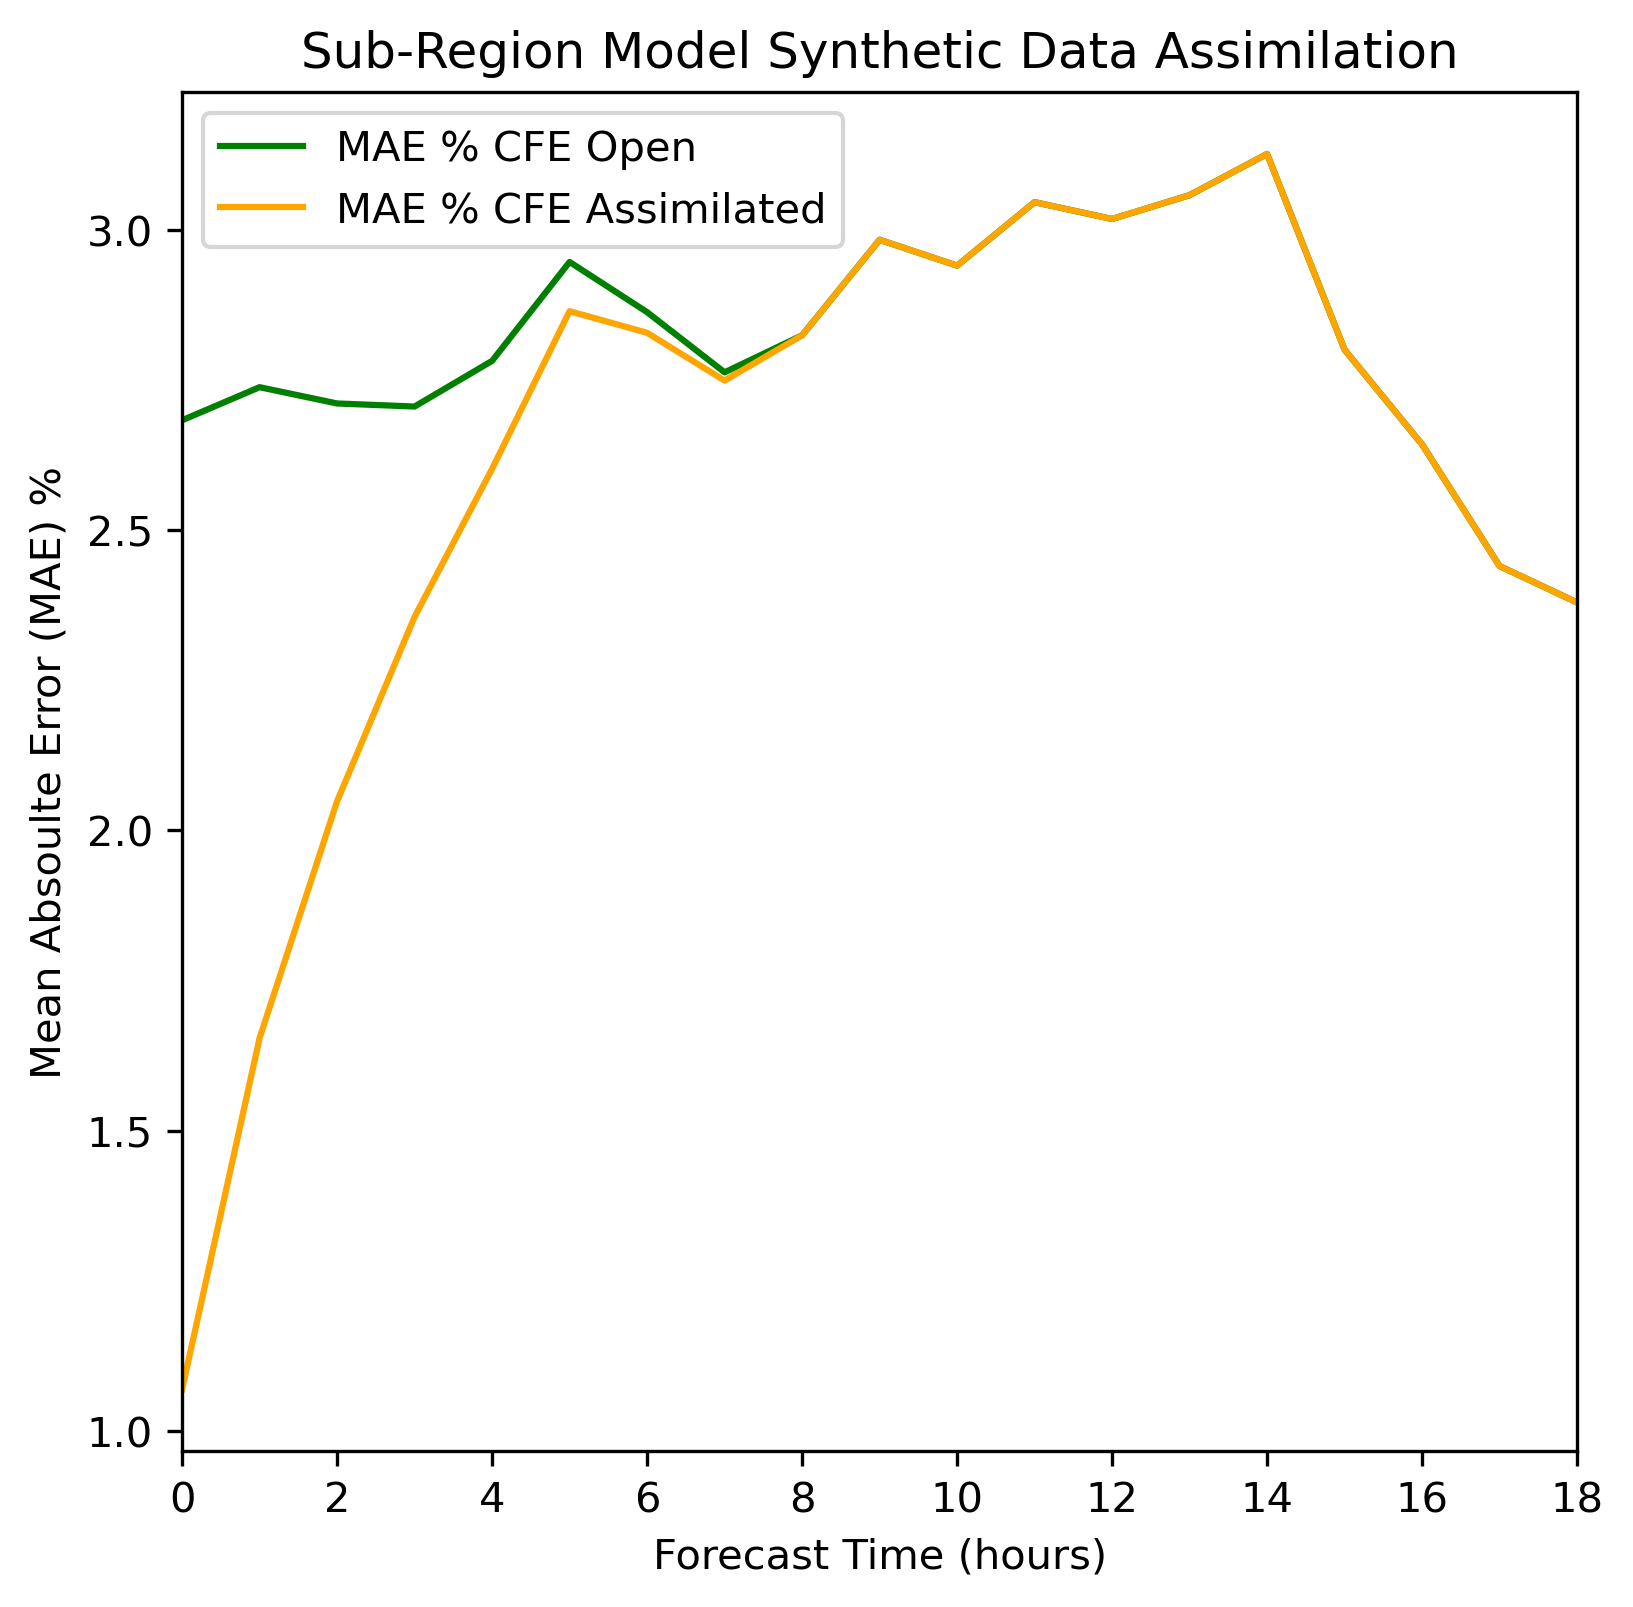

In [9]:
fig = plt.subplots(figsize = (6,6), dpi=300)
CFE_open=cfeOpen_ensa_mean
CFE_analysis=cfeanalys_ensa_mean
plt.title('Sub-Region Model Synthetic Data Assimilation')
plt.plot(CFE_open, color = 'green', label = 'MAE % CFE Open')
plt.plot(CFE_analysis, color = 'orange', label = 'MAE % CFE Assimilated')
plt.xlim(0,18)
plt.xlabel('Forecast Time (hours)')
plt.ylabel('Mean Absoulte Error (MAE) %')
plt.legend()
plt.show()



In [10]:
df=pd.DataFrame({"obs":OBSERVATIONS_LIST,"cfeAnalysis":cfeAnalysis,"cfeOpen":cfeOpen})
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [11]:
# CFE open eval
nse_open=he.evaluator(he.nse,df["obs"],df["cfeOpen"])
pbias=he.evaluator(he.pbias,df["obs"],df["cfeOpen"])
kge_open, r_open, alpha_open, beta_open = he.evaluator(he.kge, df["obs"],df["cfeOpen"])
print("r_open=",r_open[0])
print("KGE_open=",kge_open[0])
print("NSE_open=", nse_open[0])
print("PBias=", pbias[0])

# CFE Analysis
nse_analysis=he.evaluator(he.nse,df["obs"],df["cfeAnalysis"])
pbias_analysis=he.evaluator(he.pbias,df["obs"],df["cfeAnalysis"])
kge_analysis, r_analysis, alpha_analysis, beta_analysis = he.evaluator(he.kge, df["obs"],df["cfeAnalysis"])
print("r_analysis=",r_analysis[0])
print("KGE_analysis=",kge_analysis[0])
print("NSE_analysis=", nse_analysis[0])
print("PBias=", pbias_analysis[0])

print("mean_obs=",np.mean(df["obs"]))
print("STD_obs=",np.std(df["obs"]))
print("mean_open=",np.mean(df["cfeOpen"]))
print("STD_open=",np.std(df["cfeOpen"]))
print("mean_analysis=",np.mean(df["cfeAnalysis"]))
print("STD_analysis=",np.std(df["cfeAnalysis"]))

r_open= 0.9752711532378185
KGE_open= -0.0767505289500583
NSE_open= -0.8777810226868932
PBias= 84.00853906632571
r_analysis= 0.819154791062685
KGE_analysis= 0.159884819839757
NSE_analysis= 0.2284448768622953
PBias= 63.3419190625135
mean_obs= 7.82998928152997
STD_obs= 11.330467618341043
mean_open= 48.96356445483878
STD_open= 34.65822995885161
mean_analysis= 21.359517686925713
STD_analysis= 23.67469793391515
